# Mini Weka
**Disciplina: ICC204 – 'Aprendizagem de Máquina e Mineração de Dados'
Prof. Rafael Giusti (rgiusti@icomp.ufam.edu.br)**

**Objetivo**: 
    Implementar o Mini Weka, contendo seus próprios algoritmos para induzir e
empregar os modelos de classificação estudados em aula.

**Formato de entrada**: 

Os indutores e classificadores devem leem arquivos de dados no formato **ARFF**, como abaixo. 
```js
    @RELATION weather

    @ATTRIBUTE outlook {sunny, overcast, rainy}
    @ATTRIBUTE temperature REAL
    @ATTRIBUTE humidity REAL
    @ATTRIBUTE windy {TRUE, FALSE}
    @ATTRIBUTE play {yes, no}

    @DATA
    sunny,85.0,85.0,FALSE,no
    sunny,80.0,90.0,TRUE,no
    overcast,83.0,86.0,FALSE,yes
    rainy,70.0,96.0,FALSE,yes
    rainy,68.0,80.0,FALSE,yes
    rainy,65.0,70.0,TRUE,no
    ...
    %
    %
    %
```

Os classificadores aceitam arquivos que representam os modelos induzidos, isto será feito através do [*Pickles*](https://www.geeksforgeeks.org/saving-a-machine-learning-model/) para salvar e carregar nossos modelos.

## Indutores implementados
Serão ser implementados indutores para as seguintes classes de modelos:
- [Modelo probabilístico Naive Bayes](#modelo-probabilístico-naive-bayes);
- [Árvores de decisão](#árvores-de-decisão);
- [Regras](#regras);
- [Vizinhança](#vizinhaça);
- [Máquinas de vetores de suporte](#máquinas-de-vetores-de-suporte);

## Base de dados
Para testar e validar nossos modelos, usaremos duas bases de dados, a primeira com atributos numéricos e a segunda com atributos nominais. Ambas as bases terão duas versões, uma completa e a segunda com alguns atributos com valores faltando, para que possam ser tratados no preprocessamento e simular melhor dados brutos encontrados no mundo real.


In [1]:
# Para ler e visualizar os dados usaremos o scipy e pandas
import numpy as np
import pandas as pd
from scipy.io.arff import loadarff

### Iris dataset
Este talvez seja o banco de dados mais conhecido dentro de reconhecimento de padrões. O conjunto de dados contém 3 classes de 50 instâncias cada, onde cada classe se refere a um tipo de planta da íris. Uma classe é linearmente separável das outras duas, estas últimas não são entre si.

In [24]:
data, info = loadarff('../data/iris.arff')
data = pd.DataFrame(data)
info

Dataset: plant
	sepal_length's type is numeric
	sepal_width's type is numeric
	petal_length's type is numeric
	petal_width's type is numeric
	species's type is nominal, range is ('setosa', 'versicolor', 'virginica')

In [11]:
data.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
43,5.0,3.5,1.6,0.6,b'setosa'
78,6.0,2.9,4.5,1.5,b'versicolor'
29,4.7,3.2,1.6,0.2,b'setosa'
96,5.7,2.9,4.2,1.3,b'versicolor'
81,5.5,2.4,3.7,1.0,b'versicolor'


Na leitura do arquivo ARFF, os valores nominais das espécies acabaram por ser convertido no tipo Byte, para facilitar nosso trabalho vamos converter novamente para o tipo String

In [4]:
data.species = data.species.apply(lambda specie: specie.decode("utf-8"))
data.sample(5)

,sepal_length,sepal_width,petal_length,petal_width,species
113,5.7,2.5,5.0,2.0,virginica
143,6.8,3.2,5.9,2.3,virginica
45,4.8,3.0,1.4,0.3,setosa
15,5.7,4.4,1.5,0.4,setosa
130,7.4,2.8,6.1,1.9,virginica


### Tennis dataset

## Visualização dos dados

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette('husl')

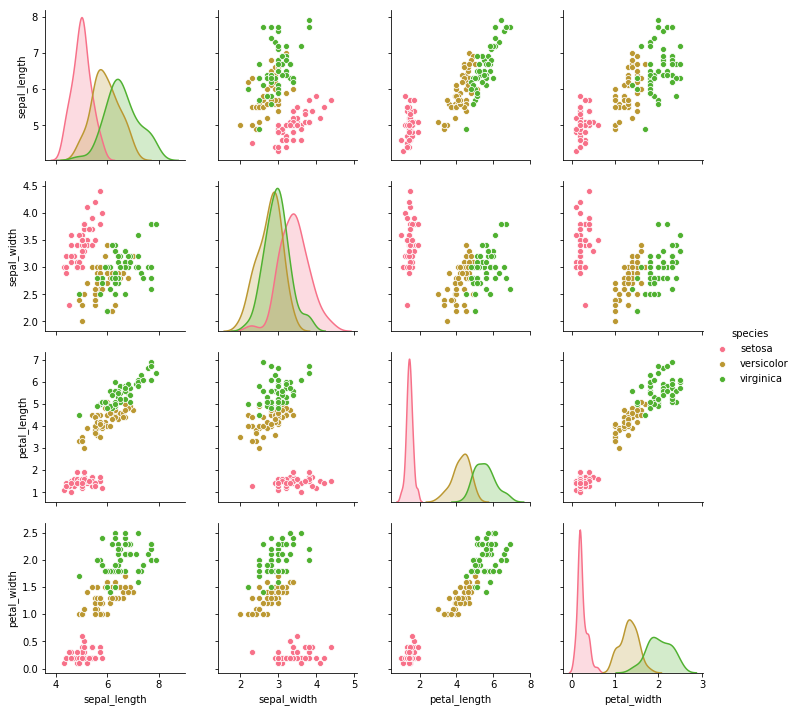

In [6]:
g = sns.pairplot(data, hue='species', markers='o')
plt.show()